In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
np.random.seed(42)

# 선형 회귀 모델 시리험

### 3-1. 실험 시나리오
- 공통의 예측 함수를 정의
- 임의의 데이터를 생성하여 예측 함수를 학습
- 학습 시 loss 함수를 비교하여 경과 비교

### 3-2. 공통 예측 함수
- 선형 회귀 분석
  - Linear Regression
  - $y = x^{\top}X + b$
- Chain Rule
  - $\frac{\partial{L}}{\partial{w}} = \frac{\partial{L}}{\partial{y_{pred}}} \cdot \frac{\partial{y_{pred}}}{\partial{w}}$
  - 따라서 backward $\rightarrow$ 손실함수는 $y_{pred}$에 대한 미분만 계산하면 됨

| 상황                       | 주로 쓰이는 손실 함수           | 예시                    |
| ------------------------ | ---------------------- | --------------------- |
| **기본 회귀 문제**             | MSE / RMSE             | 가격 예측, 수요 예측          |
| **이상치 많은 데이터**           | MAE / Huber / Log-Cosh | 센서값, 사용자 행동 데이터       |
| **상대적 오차가 중요**           | MAPE                   | 매출, 비율형 수치 예측         |
| **딥러닝 회귀 (TF/Keras 기본)** | MSE / MAE              | TensorFlow, PyTorch 등 |
| **엔지니어링용 모델 평가**         | RMSE / R²              | 품질관리, 에너지, 공정         |


In [59]:
from sklearn.datasets import make_regression
# common settings
n_epochs = 100
lr = 0.001
n_samples = 1000
n_features = 10

# logistic regression
_w = np.random.randn(n_features, 1)
_b = np.zeros([1])

# regression dataset
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=1, random_state=42)
y = y.reshape(-1, 1)

# Linear Regression
def predict(X, w, b):
    return np.dot(X, w) + b

def gradient(X, grad):
    m = len(grad)
    dw = np.dot(X.T, grad)
    db = np.sum(grad)
    return dw, db

## 회귀 전용 손실함수
## 1. MSE(Mean Squared Error)
- 정의
  - `예측값`과 `실제값`의 차이를 제곱해서 평균낸 값
  - 모델이 얼마나 틀렸는지를 평균 제곱 오차로 나타낸 지표
- 수식
  - $MSE = \frac{1}{m} \sum_i(y_i - \hat{y}_i)^2$
  - $\frac{\partial{L}}{\partial{\hat{y}}} = - \frac{2}{m}(y_i - \hat{y}_i)$
- 장점
  - 오차가 0을 중심으로 매끄럽게 변하므로 gradient descent에 적합
  - 오차가 클 수록 패널티가 크게 부여
- 단점
  - 이상치에 매우 민감 $\rightarrow$ 소수의 이상치가 큰 오차를 유발할 수 있음
  - 단위가 제곱이어여서 해석이 용이하지 않음
- 사용 예시
  - 가격 예측, 수요 예측, 딥러닝 회귀 모델

## 2. MAE(Mean Absolute Error)
- 정의
  - `예측값`과 `실제값`의 차이를 절댓값으로 하여 평균낸 값
  - 모델이 얼마나 틀렸는지를 평균 절대 오차로 나타낸 지표
- 수식
  - $MAE = \frac{1}{m} \sum_i \left\vert y_i - \hat{y}_i \right\vert$
  - $\frac{\partial{L}}{\partial{\hat{y}}} = -\frac{1}{m}\text{sign}(y_i - \hat{y}_i)$
    - $f^{\prime}(x)= \begin{cases} 1 & x > 0 \\ -1 & x \leq0 \end{cases} = \text{sign}(x)$
- 장점
  - 이상치(outlier)에 상대적으로 강건함
    - MSE는 오차의 제곱이기 때문에 상대적으로 적은 penalty
  - 실제 오차 단위와 동일하여 직관적으로 해석 가능
- 단점
  - 절댓값 때문에 gradient가 일정하여 학습 초반 속도가 느릴 수 있음
    - gradient에서 **sign** 함수는 -1 ~ +1로 오차가 커도 gradient가 커지지 않음
  - gradient가 0이 되는 구간에서 미분 불연속 $\rightarrow$ 일부 optimizer와 학습 불안정 가능
    - momentum, adam, rmsprop 등 gradient의 연속성 가정 $\rightarrow$ 불연속이면 oscillation 발생
    - gradient가 불연속(sign 함수) $\rightarrow$ 미분이 0이 되는 지점에서 값이 튀거나 정의되지 않음
- 사용 예시
    - 집값 예측, 의료 데이터 예측, 이상치가 있는 데이터 회귀

In [64]:
from src.optimizers import NAG
from src.losses.regression import MSE, MAE
from tqdm import tqdm


criterions = {
    MSE.name: MSE(),
    MAE.name: MAE(),
}

results = {}
for name, criterion in criterions.items():
    # linear regression model
    w = _w.copy()
    b = _b.copy()
    optimizer = NAG(lr) 
    loss = []
    
    for epoch in tqdm(range(n_epochs), desc=name):
        y_pred = predict(X, w, b)
    
        # loss
        _loss = criterion.forward(y, y_pred)
    
        # chain rule
        grad = criterion.backward(y, y_pred)
        dw, db = gradient(X, grad)
    
        # update
        w = optimizer.update(w, dw)
        b -= lr * db

        loss.append(_loss)

    results[name] = {
        "w":w,
        "b":b,
        "loss":loss,
        "criterion":criterion,
    }

mae: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 14278.00it/s]


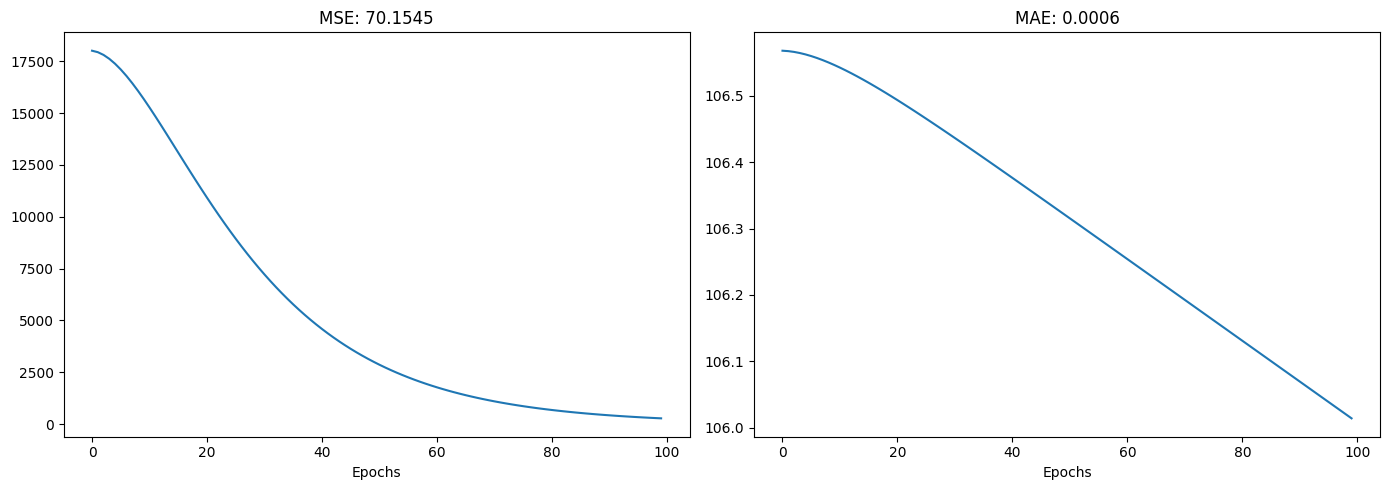

In [104]:


fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
ax = ax.flatten()

for i, loss_name in enumerate(results):
    losses = results[loss_name]["loss"]
    diff = round(losses[0] - losses[1], 4)
    ax[i].plot(losses)
    ax[i].set_title(f"{loss_name.upper()}: {diff}")
    ax[i].set_xlabel("Epochs")
plt.tight_layout()
plt.show()
    

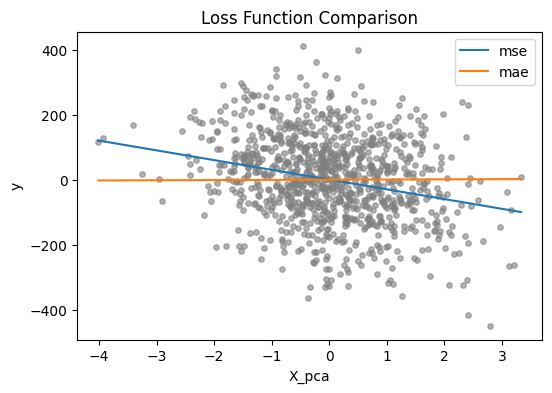

In [87]:
from sklearn.decomposition import PCA
# (2) 손실함수별로 fitting된 line 비교


# X의 차원이 n_features로 시각화에 불편함이 있으니 1차원으로 축소
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)  # (n_samples, 1)

# 데이터 시각화
plt.figure(figsize=(6,4))
plt.scatter(X_pca, y, s=15, color="gray", alpha=0.6)

# 회귀선
x_line = np.linspace(X_pca.min(), X_pca.max(), 100).reshape(-1,1)
for name, result in results.items():
    w, b = result["w"], result["b"]
    y_line = x_line * np.sum(pca.components_ @ w) + b
    plt.plot(x_line, y_line, label=name)

plt.xlabel("X_pca")
plt.ylabel("y")
plt.legend()
plt.title("Loss Function Comparison")
plt.show()
